In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

def GetNBAResult(year):
    url = 'https://www.basketball-reference.com/leagues/NBA_{}_per_game.html'.format(year)

    r = requests.get(url)
    r_html = r.text
    soup = BeautifulSoup(r_html,'html.parser')
    table = soup.find_all(class_="full_table")
    
    head = soup.find(class_="thead")
    column_names_raw =[head.text for item in head][0]
    column_names_polished=column_names_raw.replace("\n",",").split(",")[2:-1]
    #print(column_names_polished)
    
    players=[]
    
    for i in range(len(table)):
        
        player_ = []
        
        for td in table[i].find_all("td"):
            player_.append(td.text)
    
        players.append(player_)
    df = pd.DataFrame(players, columns=column_names_polished).set_index("Player")
    #cleaning the player's name from occasional special characters
    df.index = df.index.str.replace('*', '', regex=True)
    
    return df

GetNBAResult('2020')


,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
Player,,,,,,,,,,,,,,,,,,,,,
Steven Adams,C,26,OKC,63,63,26.7,4.5,7.6,.592,0.0,...,.582,3.3,6.0,9.3,2.3,0.8,1.1,1.5,1.9,10.9
Bam Adebayo,PF,22,MIA,72,72,33.6,6.1,11.0,.557,0.0,...,.691,2.4,7.8,10.2,5.1,1.1,1.3,2.8,2.5,15.9
LaMarcus Aldridge,C,34,SAS,53,53,33.1,7.4,15.0,.493,1.2,...,.827,1.9,5.5,7.4,2.4,0.7,1.6,1.4,2.4,18.9
Kyle Alexander,C,23,MIA,2,0,6.5,0.5,1.0,.500,0.0,...,,1.0,0.5,1.5,0.0,0.0,0.0,0.5,0.5,1.0
Nickeil Alexander-Walker,SG,21,NOP,47,1,12.6,2.1,5.7,.368,1.0,...,.676,0.2,1.6,1.8,1.9,0.4,0.2,1.1,1.2,5.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Trae Young,PG,21,ATL,60,60,35.3,9.1,20.8,.437,3.4,...,.860,0.5,3.7,4.3,9.3,1.1,0.1,4.8,1.7,29.6
Cody Zeller,C,27,CHO,58,39,23.1,4.3,8.3,.524,0.3,...,.682,2.8,4.3,7.1,1.5,0.7,0.4,1.3,2.4,11.1
Tyler Zeller,C,30,SAS,2,0,2.0,0.5,2.0,.250,0.0,...,,1.5,0.5,2.0,0.0,0.0,0.0,0.0,0.0,1.0


In [3]:
#Import de la librairie pandas
import pandas

#Lecture des fichiers de données en spécifiant le séparateur point-virgule ';'
equipeJO = pandas.read_csv("20162020_JO_Team.csv", sep=';')
joueurJO2016 = pandas.read_csv("2016_JO_Player.csv", sep=';')
joueurNBA2016 = pandas.read_csv("2016_NBA_Player.csv", sep=';')
joueurNBAWP2016 = pandas.read_csv("2016_NBA_Player_WP.csv", sep=';')
equipeNBA2016 = pandas.read_csv("2016_NBA_Team.csv", sep=';')
joueurJO2020 = pandas.read_csv("2020_JO_Player.csv", sep=';')
joueurNBA2020 = pandas.read_csv("2020_NBA_Player.csv", sep=';')
equipeNBA2020 = pandas.read_csv("2020_NBA_Team.csv", sep=';')

#print(notes.dtypes)
joueurJO2020

,Name,Age,Team,Position,Games Played,Game Started,Field Goals Made,Field Goals Attempted,Field Goals Made Percentage,3 Point Made,...,Total Rebounds,Rebounds Average,Total Points,Points Average,Total Assists,Assists Average,Total Blocks,Blocks Average,Steals,Steals Average
0,Kevin Durant,33,Brooklyn Nets,F,6,6,45,85,0.52,15,...,32,5.3,124,20.7,22,3.67,7,1.17,6,1.00
1,Jayson Tatum,24,Boston Celtics,F,6,0,33,67,0.49,17,...,20,3.3,91,15.2,7,1.17,7,1.17,3,0.50
2,Jrue Holiday,31,Milwaukee Bucks,G,6,5,28,58,0.48,7,...,29,4.8,71,11.8,23,3.83,5,0.83,10,1.67
3,Damian Lillard,31,Portland Trail Blazers,G,6,6,23,60,0.38,16,...,16,2.7,67,11.2,19,3.17,0,0.00,3,0.50
4,Zach LaVine,27,Chicago Bulls,G,6,1,21,35,0.60,10,...,12,2.0,58,9.7,20,3.33,0,0.00,5,0.83
5,Devin Booker,25,Phoenix Suns,G,6,5,19,45,0.42,5,...,19,3.4,56,9.3,11,1.83,2,0.33,9,1.50
6,Bam Adebayo,24,Miami Heat,F/C,6,6,16,28,0.57,0,...,34,5.7,38,6.3,11,1.83,7,1.17,8,1.33
7,JaVale McGee,34,Denver Nuggets,C,4,0,10,13,0.76,0,...,5,1.3,25,6.3,0,0.00,2,0.50,2,0.50
8,Khris Middleton,30,Milwaukee Bucks,F,6,0,14,31,0.45,6,...,11,1.8,35,5.8,10,1.67,5,0.83,5,0.83
9,Draymond Green,32,Golden State Warriors,F,6,1,7,9,0.77,3,...,18,3.0,21,3.5,17,2.83,7,1.17,7,1.17


Quel est la corrélation entre la participation aux Olympiques et le classements des joueurs dans la NBA?

In [4]:
# jointure
#df_sales_full = df_sales.join(df_product.set_index("product_id"), on="product_id")

#print(joueurJO2016.columns)
joueur2016 = joueurJO2016.join(joueurNBA2016.where(joueurNBA2016['Rank'] <= 12).set_index('Name'), on="Name", lsuffix='JO', rsuffix='NBA', how='inner').sort_values(by=['Rank'])
joueur2020 = joueurJO2020.join(joueurNBA2020.where(joueurNBA2020['Rank'] <= 12).set_index('Name'), on="Name", lsuffix='JO', rsuffix='NBA', how='inner').sort_values(by=['Rank'])

#joueur2020.transpose()
joueur2016

,Name,AgeJO,TeamJO,PositionJO,Games PlayedJO,Game Started,Field Goals Made,Field Goals Attempted,Field Goals Made PercentageJO,3 Point Made,...,3 Point Attempted Per Game,3 Point Made Percentage,Free Throws Made Per Game,Free Throws Attempted Per Game,Free Throws Made PercentageNBA,Rebounds Per Game,Assists per game,Steals Per Game,Blocks per Game,Points Per game
4,DeMar DeRozan,26.0,NaN,G,7,0,16,27,0.593,0,...,1.7,26.6,7.4,8.7,84.2,5.2,3.9,1.1,0.2,27.3
3,DeMarcus Cousins,25.0,NaN,C,8,5,27,44,0.614,0,...,5.0,36.1,7.2,9.3,77.2,11.0,4.6,1.4,1.3,27.0
8,Kyrie Irving,NaN,NaN,G,8,8,31,65,0.477,9,...,6.1,40.1,4.1,4.6,90.5,3.2,5.8,1.2,0.3,25.2


Est-ce que les joueurs de la NBA ont une performance similaire moyenne en saison régulière comparé aux olympiques (Points, rebound, assist et block)?

Est-ce que la performance moyenne d'une équipe de la NBA est semblable à une équipe Olympique?

Est-ce que l'écart-type est similaire entre les joueurs d'une équipe de la NBA et ceux d'une équipe Olympique?

In [5]:
##1.1.L'ÉCART-TYPE DES JOUEURS NBA 2016(stdjoNBA2016):
stdjoNBA2016 = joueurNBA2016.agg(
    {"Points Per game": ["std"],
           "Rebounds Per Game": ["std"],
           "Assists per game":["std"],
           "Blocks per Game": ["std"]}).transpose()
stdjoNBA2016

,std
Points Per game,2.385808
Rebounds Per Game,3.096564
Assists per game,2.765744
Blocks per Game,0.540248


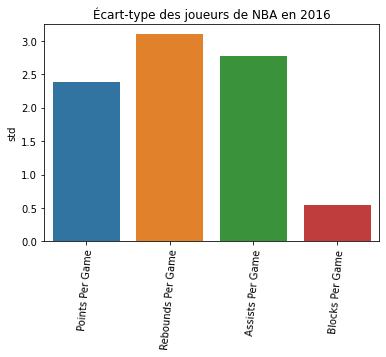

In [34]:
import seaborn
graph_stdjoNBA2016 = seaborn.barplot(x=['Points Per Game','Rebounds Per Game','Assists Per Game','Blocks Per Game'] ,y='std',data=stdjoNBA2016)
for item in graph_stdjoNBA2016.get_xticklabels():
        item.set_rotation(85)
        graph_stdjoNBA2016.set_title('Écart-type des joueurs de NBA en 2016')

In [7]:
##1.2.L'ÉCART-TYPE DES JOUEURS DE NBA 2020(stdjoNBA2020):
stdjoNBA2020 = joueurNBA2020.agg(
    {"Points Per game": ["std"],
           "Rebounds Per Game": ["std"],
           "Assists per game":["std"],
           "Blocks per Game": ["std"]}).transpose()
stdjoNBA2020

,std
Points Per game,2.596171
Rebounds Per Game,2.879012
Assists per game,1.860751
Blocks per Game,0.394168


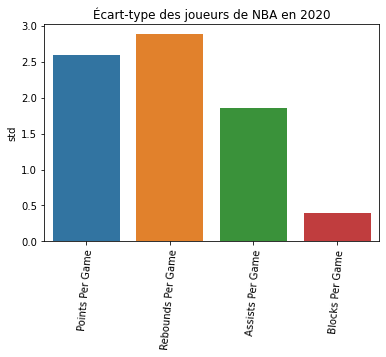

In [32]:
graph_stdjoNBA2020 = seaborn.barplot(x=['Points Per Game','Rebounds Per Game','Assists Per Game','Blocks Per Game'] ,y='std',data=stdjoNBA2020)
for item in graph_stdjoNBA2020.get_xticklabels():
        item.set_rotation(85)
        graph_stdjoNBA2020.set_title('Écart-type des joueurs de NBA en 2020') 

In [9]:
##1.3.L'ÉCART-TYPE DES JOUEURS DE OLYMPIQUE 2016(stdjoOLY2016):
stdjoOLY2016= joueurJO2016.agg({"Points Average": ["std"],
           "Rebounds Average": ["std"],
           "Assists Average":["std"],
           "Average Blocks": ["std"]}).transpose()
stdjoOLY2016

,std
Points Average,4.638639
Rebounds Average,1.672958
Assists Average,1.105494
Average Blocks,0.259452


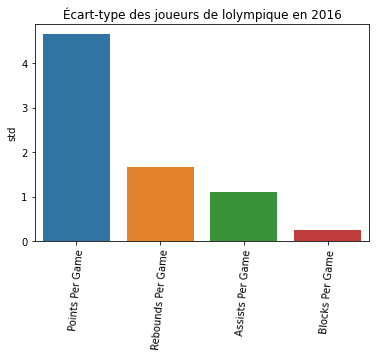

In [31]:
graph_stdjoOLY2016 = seaborn.barplot(x=['Points Per Game','Rebounds Per Game','Assists Per Game','Blocks Per Game'] ,y='std',data=stdjoOLY2016)
for item in graph_stdjoOLY2016.get_xticklabels():
        item.set_rotation(85)
        graph_stdjoOLY2016.set_title('Écart-type des joueurs de lolympique en 2016') 

In [11]:
##1.3.L'ÉCART-TYPE DES JOUEURS DE OLYMPIQUE 2020(stdjoOLY2020):
stdjoOLY2020= joueurJO2020.agg({"Points Average": ["std"],
           "Rebounds Average": ["std"],
           "Assists Average":["std"],
           "Blocks Average": ["std"]}).transpose()
stdjoOLY2020

,std
Points Average,5.787578
Rebounds Average,1.628999
Assists Average,1.275207
Blocks Average,0.494218


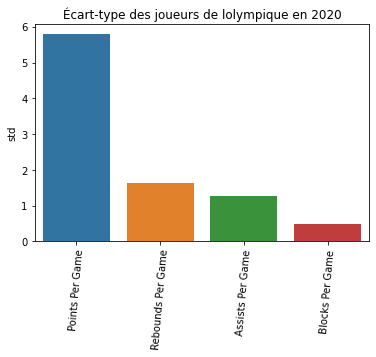

In [30]:
graph_stdjoOLY2020 = seaborn.barplot(x=['Points Per Game','Rebounds Per Game','Assists Per Game','Blocks Per Game'] ,y='std',data=stdjoOLY2020)
for item in graph_stdjoOLY2020.get_xticklabels():
        item.set_rotation(85)
        graph_stdjoOLY2020.set_title('Écart-type des joueurs de lolympique en 2020') 

In [13]:
##2.1.TROUVER L'ÉCART-TYPE L'ÉQUIPE NBA 2016(stdEquipeNBA2016):
stdEquipeNBA2016 = equipeNBA2016.agg(
    {"Points Per Game": ["std"],
           "Rebounds Per Game": ["std"],
           "Assists Per Game":["std"],
           "Blocks Per Game": ["std"]}).transpose()
stdEquipeNBA2016

,std
Points Per Game,4.128901
Rebounds Per Game,1.716991
Assists Per Game,2.216231
Blocks Per Game,0.713748


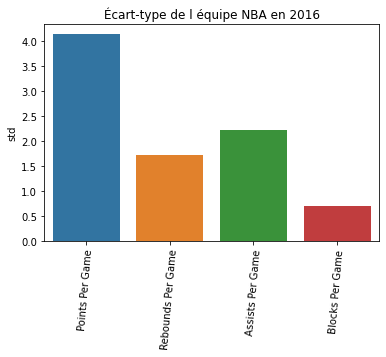

In [28]:
graph_stdEquipeNBA2016 = seaborn.barplot(x=['Points Per Game','Rebounds Per Game','Assists Per Game','Blocks Per Game'] ,y='std',data=stdEquipeNBA2016)
for item in graph_stdEquipeNBA2016.get_xticklabels():
        item.set_rotation(85)
        graph_stdEquipeNBA2016.set_title('Écart-type de l équipe NBA en 2016') 

In [15]:
##2.1.TROUVER L'ÉCART-TYPE L'ÉQUIPE NBA 2020(stdEquipeNBA2016):
stdEquipeNBA2020 = equipeNBA2020.agg(
    {"Points Per Game": ["std"],
           "Rebounds Per Game": ["std"],
           "Assists Per Game":["std"],
           "Blocks Per Game": ["std"]}).transpose()
stdEquipeNBA2020

,std
Points Per Game,4.140692
Rebounds Per Game,1.777639
Assists Per Game,1.835650
Blocks Per Game,0.585102


### 

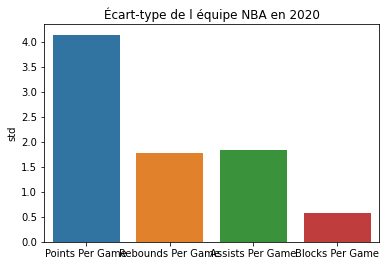

In [27]:
graph_stdEquipeNBA2020 = seaborn.barplot(x=['Points Per Game','Rebounds Per Game','Assists Per Game','Blocks Per Game'] ,y='std',data=stdEquipeNBA2020)
for item in graph_stdEquipeNBA2016.get_xticklabels():
        item.set_rotation(85)
        graph_stdEquipeNBA2020.set_title('Écart-type de l équipe NBA en 2020') 

In [17]:
##2.2.TROUVER L'ÉCART-TYPE L'ÉQUIPE Olympique 2016-2020(stdEquipeOly20162020):

stdEquipeOly20162020 = equipeJO.agg(
    {"Points per game": ["std"],
           "Rebounds per game": ["std"],
           "Assists per game":["std"],
           "Turnovers per game": ["std"]}).transpose()
stdEquipeOly20162020

,std
Points per game,1.343503
Rebounds per game,5.868986
Assists per game,0.212132
Turnovers per game,1.060660


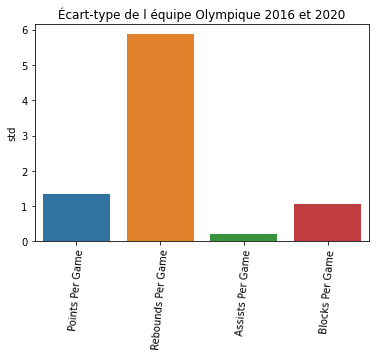

In [25]:
# L'écart type de l'année 2016 et 2020 pour l'équipe Olympique
graph_stdEquipeOly20162020 = seaborn.barplot(x=['Points Per Game','Rebounds Per Game','Assists Per Game','Blocks Per Game'] ,y='std',data=stdEquipeOly20162020)
for item in graph_stdEquipeOly20162020.get_xticklabels():
        item.set_rotation(85)
        graph_stdEquipeOly20162020.set_title('Écart-type de l équipe Olympique 2016 et 2020') 
        